In [2]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from linear_sca import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

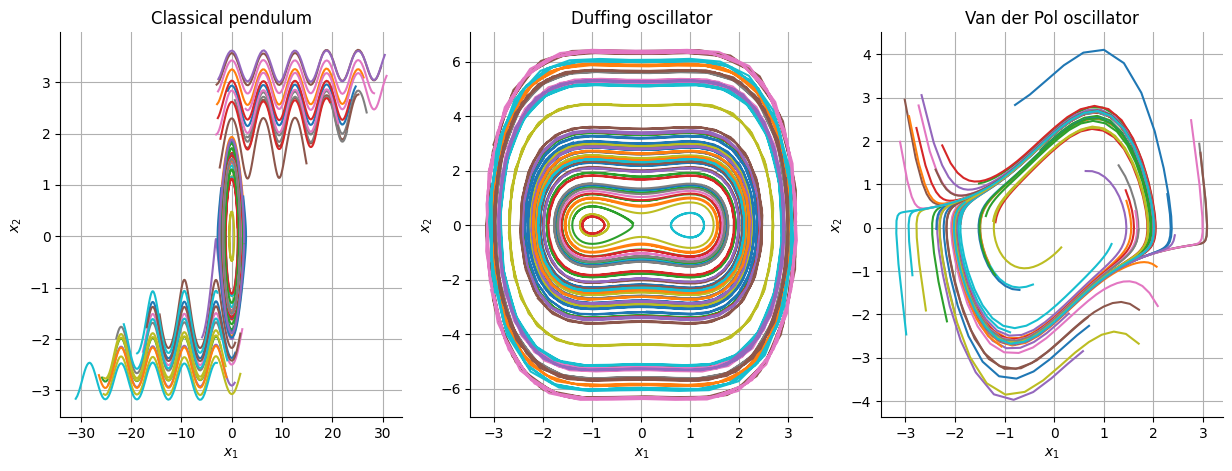

In [3]:
def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2
    dx2_dt = -np.sin(x1)
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2
    dx2_dt = x1 - x1**3
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2
    dx2_dt = (1 - x1**2) * x2 - x1
    return [dx1_dt, dx2_dt]



t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 100)     # time points where the solution is computed


num_trajectories = 50

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(pendulum_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[0].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[0].set_title('Classical pendulum')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(duffing_oscillator, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[1].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[1].set_title('Duffing oscillator')

for initial_conditions in initial_conditions_list:
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    axs[2].plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')
    axs[2].set_title('Van der Pol oscillator')

for ax in axs:
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.grid()
    ax.spines[['right', 'top']].set_visible(False)


In [4]:
#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(van_der_pol, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)

In [5]:
key = random.PRNGKey(seed)
key, subkey = random.split(key)

proj_dims = 30
proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)

X_projected = jnp.einsum('lj,ijk->ilk', proj_matrix, X)         #(K, N', T)

noise = random.normal(key, (X_projected.shape[1],)) 
X_projected += noise[None, : , None]
X_projected = jnp.array(X_projected)

In [39]:
U, ls_loss = optimize(X_projected[10:], d=2, learning_rate=0.001, iterations=10000) 

Iteration 0, S: 38.37370681762695
Iteration 10, S: 33.07451629638672
Iteration 20, S: 76.9925308227539
Iteration 30, S: 90.22523498535156
Iteration 40, S: 59.908416748046875
Iteration 50, S: 57.77571105957031
Iteration 60, S: 91.5932388305664
Iteration 70, S: 281.62176513671875
Iteration 80, S: 246.26695251464844
Iteration 90, S: 259.9833068847656
Iteration 100, S: 611.2196044921875
Iteration 110, S: 723.7445678710938
Iteration 120, S: 655.0798950195312
Iteration 130, S: 1278.56201171875
Iteration 140, S: 1147.3125
Iteration 150, S: 1478.5853271484375
Iteration 160, S: 3862.064208984375
Iteration 170, S: 6213.1904296875
Iteration 180, S: 8607.6376953125
Iteration 190, S: 9842.3447265625
Iteration 200, S: 18452.330078125
Iteration 210, S: 21282.29296875
Iteration 220, S: 30583.3984375
Iteration 230, S: 37382.9375
Iteration 240, S: 39055.12109375
Iteration 250, S: -54437.01953125
Iteration 260, S: -60280.51953125
Iteration 270, S: 60973.3046875
Iteration 280, S: -59603.5234375
Iteration 

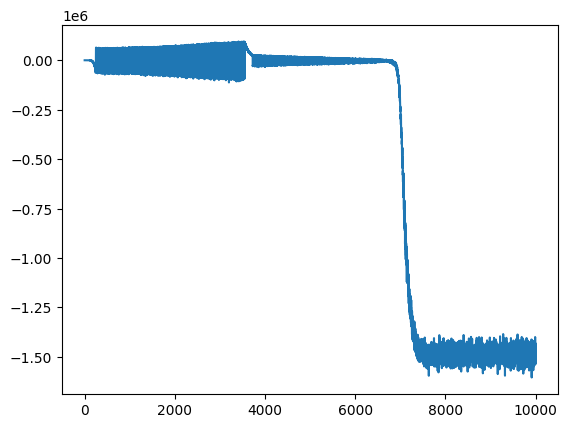

In [40]:
plt.plot(ls_loss)

In [70]:
def plot_2D(Y):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    cmap = plt.get_cmap('viridis')      #RdBu

    num_time_points = Y.shape[-1]
    indices_to_plot = np.arange(0, Y.shape[0], 1)

    for i in indices_to_plot:
        x = Y[i, 0, :]  
        y = Y[i, 1, :]  
        
        for t in range(num_time_points - 1):
            ax.plot(x[t:t+2], y[t:t+2], color=cmap(t / (num_time_points - 1)))

    #ax.set_xlabel('SC 1')
    #ax.set_ylabel('SC 2')
    ax.spines[['top','right']].set_visible(False)
    #ax.set_xticks([])
    #ax.set_yticks([])
    #plt.grid()

#Variance explained:
def var_explained(X, U):
    """ X is K, N, T 
        U is N, d """
    X_reshaped = np.concatenate(X.swapaxes(1,2))    #(K*T, N)                #X_reshaped -= np.mean(X_reshaped, axis = 0) sigma = np.dot(X_reshaped.T, X_reshaped)
    sigma = np.cov(X_reshaped.T)
    return np.trace(U.T @ sigma @ U) / np.trace(sigma)

Text(0.5, 1.0, 'sca 0.3217649146471156')

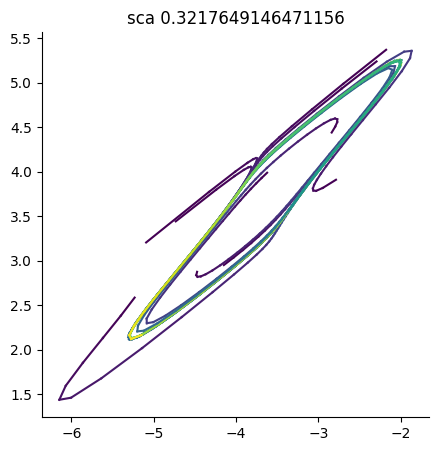

In [71]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X_projected[:10])
plot_2D(Y)
plt.title(f"sca {var_explained(X_projected[:10], U_qr)}")


Text(0.5, 1.0, 'pca 1.0000001678645054')

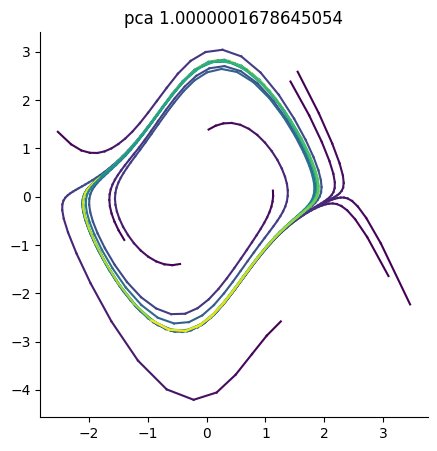

In [72]:
""" PCA """
split = 10
X_train = np.concatenate(X_projected[split:].swapaxes(1,2))
X_test = np.concatenate(X_projected[:split].swapaxes(1,2))
full_data_var = np.sum(np.var(X_test, axis=0))

num_pcs = 2
pca = PCA(num_pcs)
X_pca = pca.fit(X_train).transform(X_test)
PCs = pca.components_
X_pca = X_pca.reshape(split, len(t_eval), num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(X_pca)
plt.title(f"pca {var_explained(X_projected[:10], PCs.T)}")

